#**1.Data Loading and Preprocessing - Performing Initial Cleaning and preparing it for Analysis**

---



In [ ]:
import pandas as pd
import matplotlib.pyplot as matplt
import seaborn as sns

# Load the data
data = pd.read_csv('Fraud_check.csv')
data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [ ]:
# Create the 'Risk' column based on 'Taxable.Income'
data['Risk'] = data['Taxable.Income'].apply(lambda x: 0 if x <= 30000 else 1)

In [ ]:
# Drop unrelated columns
data = data.drop(['City.Population', 'Taxable.Income'], axis=1)
print(data.head())

  Undergrad Marital.Status  Work.Experience Urban  Risk
0        NO         Single               10   YES     1
1       YES       Divorced               18   YES     1
2        NO        Married               30   YES     1
3       YES         Single               15   YES     1
4        NO        Married               28    NO     1


#**2. Exploratory Data Analysis (EDA)**


*Let us analyse and investigate data set and summarize the main characteristics, and employ data visualization methods.*


---



In [ ]:
#Check for categorical data and numerical data
categorical_attributes = data.describe(include=["object"]).columns
print(categorical_attributes)

numerical_attributes = data.describe(include=["int64"]).columns
print(numerical_attributes)

#check if data has any missing values
print(data.isnull().sum())

#Check if Risk column was correctly split into Risky and Good
print(data['Risk'].value_counts())

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')
Index(['Work.Experience', 'Risk'], dtype='object')
Undergrad          0
Marital.Status     0
Work.Experience    0
Urban              0
Risk               0
dtype: int64
Risk
1    476
0    124
Name: count, dtype: int64


<ipython-input-45-9f57bb7077ef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk', data=data, palette = 'viridis', order=data['Risk'].value_counts().index)


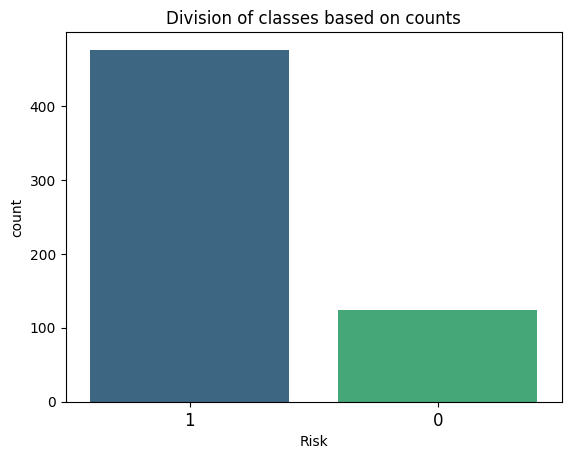

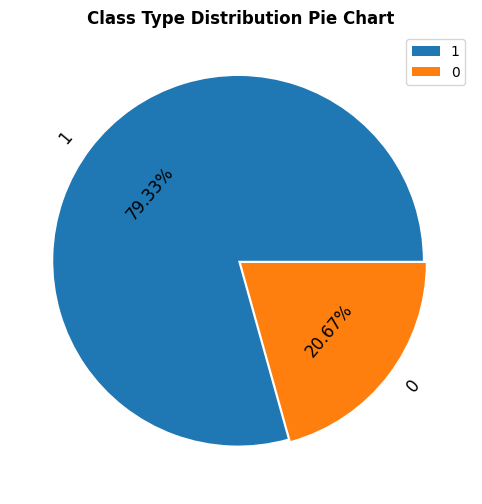

In [ ]:
#Let us see visually how the split between the two classes look
sns.countplot(x='Risk', data=data, palette = 'viridis', order=data['Risk'].value_counts().index)
matplt.xticks(fontsize = 12)
matplt.title('Division of classes based on counts')
matplt.show()

#Checking for Imbalanced or balanced dataset with regards to the Target
matplt.figure(figsize = (9,6))
matplt.pie(data['Risk'].value_counts(),labels= data['Risk'].unique(),
       explode = [0.02,0.0], autopct= '%.2f%%',textprops = {'size':'large','rotation':50,'color':'black'})
matplt.legend(loc= 'upper right')
matplt.title("Class Type Distribution Pie Chart", fontsize = 12, fontweight = 'bold')
matplt.show()

In [ ]:
# Convert categorical columns into numerical format (binary or multiple values)
data['Marital.Status'] = data['Marital.Status'].map({"Single": 0, "Married": 1, "Divorced": 2})

data['Urban'] = data['Urban'].map({"YES": 1, "NO": 0})

data['Undergrad'] = data['Undergrad'].map({"YES": 1, "NO": 0})

data

,Undergrad,Marital.Status,Work.Experience,Urban,Risk
0,0,0,10,1,1
1,1,2,18,1,1
2,0,1,30,1,1
3,1,0,15,1,1
4,0,1,28,0,1
...,...,...,...,...,...
595,1,2,7,1,1
596,1,2,2,1,1
597,0,2,0,1,1
598,1,1,17,0,1


#**3. Data split into training and testing sets**






In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
features = data.iloc[:,0:4]
print(features)

labels=data['Risk']
print(labels)

# Perform the split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Check the shape of the data
print("Shape of x_train : ",X_train.shape)
print("Shape of x_test  : ",X_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

     Undergrad  Marital.Status  Work.Experience  Urban
0            0               0               10      1
1            1               2               18      1
2            0               1               30      1
3            1               0               15      1
4            0               1               28      0
..         ...             ...              ...    ...
595          1               2                7      1
596          1               2                2      1
597          0               2                0      1
598          1               1               17      0
599          0               2               16      0

[600 rows x 4 columns]
0      1
1      1
2      1
3      1
4      1
      ..
595    1
596    1
597    1
598    1
599    1
Name: Risk, Length: 600, dtype: int64
Shape of x_train :  (480, 4)
Shape of x_test  :  (120, 4)
Shape of y_train :  (480,)
Shape of y_test  :  (120,)


#**4. Defining GINI Index and Information Gain**


In [ ]:
import numpy as np
def compute_gini_index(partitions, target_labels):
    """
    Compute the Gini Index (impurity) for the dataset partitions.

    Args:
        partitions (list of lists): Subsets of data after splitting.
        target_labels (list): List of unique target class labels.

    Returns:
        float: The computed Gini index for the given partitions.
    """
    # Calculate the total number of instances in all partitions
    total_instances = float(sum([len(subset) for subset in partitions]))

    # Initialize Gini index to zero
    gini_index = 0.0

    # Iterate through each partition to calculate the Gini index
    for subset in partitions:
        subset_size = float(len(subset))
        if subset_size == 0:  # Skip if the subset is empty
            continue

        # Calculate the probability of each class in the subset
        subset_score = 0.0
        for label in target_labels:
            label_proportion = [record[-1] for record in subset].count(label) / subset_size
            subset_score += label_proportion ** 2

        # Calculate weighted Gini for this subset
        gini_index += (1.0 - subset_score) * (subset_size / total_instances)

    return gini_index

def partition_data(feature_idx, threshold_value, data):
    """
    Partition the dataset into two subsets based on a given feature and threshold.

    Args:
        feature_idx (int): Index of the feature to use for the partition.
        threshold_value (float): Value to split the data at.
        data (list of lists): The dataset to partition.

    Returns:
        tuple: Two subsets of the data, one for values below the threshold and one for above.
    """
    left_partition, right_partition = list(), list()

    # Split the data into the two subsets
    for record in data:
        if record[feature_idx] < threshold_value:
            left_partition.append(record)
        else:
            right_partition.append(record)

    return left_partition, right_partition

def identify_optimal_split(data):
    """
    Find the optimal feature and threshold to split the dataset based on the lowest Gini index.

    Args:
        data (list of lists): The dataset to find the best split for.

    Returns:
        dict: A dictionary containing the best split feature index, threshold value, and resulting partitions.
    """
    # Extract unique class labels from the dataset
    unique_labels = list(set(row[-1] for row in data))

    # Initialize variables to track the best split (start with very large values)
    optimal_feature_idx, optimal_threshold, lowest_gini, optimal_partitions =  999, 999, 999, None

    # Iterate over each feature (excluding the target column)
    for feature_idx in range(len(data[0]) - 1):
        for record in data:
            # Partition the dataset based on the current feature and threshold
            partitions = partition_data(feature_idx, record[feature_idx], data)

            # Calculate the Gini index for this split
            gini_value = compute_gini_index(partitions, unique_labels)

            # If the Gini index is lower than the current best, update the optimal split
            if gini_value < lowest_gini:
                optimal_feature_idx, optimal_threshold, lowest_gini, optimal_partitions = feature_idx, record[feature_idx], gini_value, partitions

    # Return the best split information in a dictionary
    return {'feature_index': optimal_feature_idx, 'threshold': optimal_threshold, 'partitions': optimal_partitions}

#**4. Constructing and Training the Decision Tree Model**


In [ ]:
# Function to determine the terminal node (final decision) based on the majority class
def create_leaf_node(data_group):
    """
    Create a terminal node that predicts the majority class of the group.

    Args:
        data_group (list): A group of data rows.

    Returns:
        The most frequent class label in the group.
    """
    outcomes = [row[-1] for row in data_group]
    return max(set(outcomes), key=outcomes.count)

# Recursive function to split nodes and build the tree
def recursive_split(node, max_depth, min_samples, current_depth):
    """
    Recursively split nodes until a stopping criterion is met (max depth or min samples).

    Args:
        node (dict): The current node being split.
        max_depth (int): Maximum allowed depth of the tree.
        min_samples (int): Minimum number of samples required to split a node.
        current_depth (int): The current depth of the tree during recursion.
    """
    left_branch, right_branch = node['partitions']
    del(node['partitions'])  # Once we split, we don't need the raw groups anymore

    # If a node has no data on either side, make both sides terminal
    if not left_branch or not right_branch:
        node['left'] = node['right'] = create_leaf_node(left_branch + right_branch)
        return

    # If we have reached the maximum depth, make both sides terminal
    if current_depth >= max_depth:
        node['left'], node['right'] = create_leaf_node(left_branch), create_leaf_node(right_branch)
        return

    # Process left branch
    if len(left_branch) <= min_samples:
        node['left'] = create_leaf_node(left_branch)
    else:
        node['left'] = identify_optimal_split(left_branch)
        recursive_split(node['left'], max_depth, min_samples, current_depth + 1)

    # Process right branch
    if len(right_branch) <= min_samples:
        node['right'] = create_leaf_node(right_branch)
    else:
        node['right'] = identify_optimal_split(right_branch)
        recursive_split(node['right'], max_depth, min_samples, current_depth + 1)

# Function to initiate tree building by identifying the best split for the root
def construct_decision_tree(training_data, max_depth, min_samples):
    """
    Build the decision tree using the training data, starting from the root.

    Args:
        training_data (list): The training dataset to build the tree.
        max_depth (int): Maximum depth the tree can grow to.
        min_samples (int): Minimum number of samples required to split a node.

    Returns:
        dict: The root node of the constructed decision tree.
    """
    # Get the best possible initial split for the root
    root_node = identify_optimal_split(training_data)
    recursive_split(root_node, max_depth, min_samples, 1)
    return root_node



In [ ]:
# Function to make predictions using the constructed decision tree
def make_prediction(tree_node, data_row):
    """
    Predict the class label for a given data row using the decision tree.

    Args:
        tree_node (dict): The current node in the decision tree.
        data_row (list): A single row of data for which we want to predict the class.

    Returns:
        The predicted class label.
    """
    # Check if the row value for the current node's feature is less than the split value
    if data_row[tree_node['feature_index']] < tree_node['threshold']:
        # If the left branch is another node, recurse, otherwise return the leaf value
        if isinstance(tree_node['left'], dict):
            return make_prediction(tree_node['left'], data_row)
        else:
            return tree_node['left']
    else:
        # If the right branch is another node, recurse, otherwise return the leaf value
        if isinstance(tree_node['right'], dict):
            return make_prediction(tree_node['right'], data_row)
        else:
            return tree_node['right']

# Function to apply the decision tree to a test dataset
def run_decision_tree(train_data, test_data, max_depth, min_samples):
    """
    Train a decision tree and make predictions on the test data.

    Args:
        train_data (list): The training dataset used to build the tree.
        test_data (list): The test dataset used to make predictions.
        max_depth (int): The maximum depth of the tree.
        min_samples (int): The minimum number of samples required to split a node.

    Returns:
        list: A list of predicted class labels for the test data.
    """
    # Build the decision tree using the training data
    decision_tree_root = construct_decision_tree(train_data, max_depth, min_samples)

    # Generate predictions for each row in the test data
    predictions = list()
    for data_row in test_data:
      prediction = make_prediction(decision_tree_root,data_row)
      predictions.append(prediction)
    return predictions

#**5. Testing the model and accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Prepare the data by merging feature and target arrays into a single dataset
training_dataset = np.array(pd.concat([X_train, y_train], axis=1))
testing_dataset = np.array(pd.concat([X_test, y_test], axis=1))

# Train the decision tree and get predictions for the test dataset
predicted_labels = run_decision_tree(training_dataset, testing_dataset, max_depth=5, min_samples=10)

# Convert actual and predicted labels to integer format (if needed)
actual = testing_dataset[:, -1]
actual = actual.astype(int)
predicted_labels = np.array(predicted_labels).astype(int)

# Calculate the accuracy score by comparing actual and predicted labels
accuracy = accuracy_score(actual, predicted_labels)
print(f"Accuracy Score: {accuracy * 100:.2f}%")


Accuracy Score: 77.50%


#**6. Execution Time calculation**

In [ ]:
import time

startTime = time.time()
predicted_labels = run_decision_tree(training_dataset, testing_dataset, max_depth=5, min_samples=10)
endTime = time.time()

print("executionTime = ", endTime - startTime)

executionTime =  1.6073479652404785
